<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn
!pip install yfinance

     |████████████████████████████████| 374 kB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=54af9f41cec0cddcf7d976b4e5b8d2a0b0ea638d991ca201f379d04bf9ea157e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from hmmlearn import hmm
import yfinance as yf

In [3]:
df = yf.download('^nsei',start='2015-01-01')#period='max'

[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [5]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900


In [6]:
returns = np.log(df['Close']).diff(8)

In [7]:
returns.dropna(inplace=True)

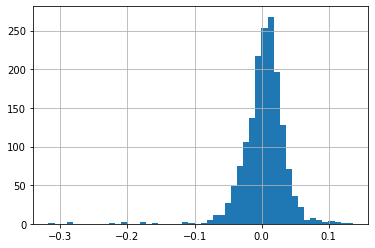

In [8]:
returns.hist(bins=50);

In [9]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [10]:
#retu = np.column_stack([returns]) =====> returns.to_numpy().reshape(-1, 1)


In [11]:
X = returns.to_numpy().reshape(-1, 1)
print(X.shape)
model.fit(X)

(1654, 1)


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [12]:
Z = model.predict(X)

In [13]:
Z

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

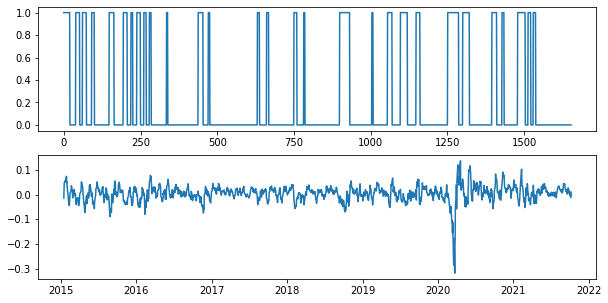

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

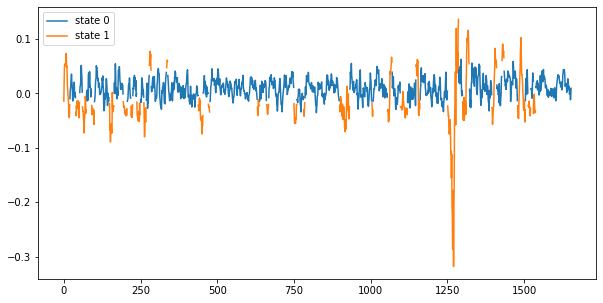

In [15]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [16]:
# transition matrix
model.transmat_

array([[0.96419027, 0.03580973],
       [0.09891208, 0.90108792]])

In [17]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [18]:
# run inference again
Z = model.predict(X)
ret=returns.reset_index()
zi= pd.concat([ret.Date,pd.Series(Z)],axis=1)
zi=zi.set_index('Date')
zi.columns=['pred']



In [19]:
def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.pred.iloc[i]==1 and df.pred.iloc[i-1]==0 :
      reg1.append(i)
    elif df.pred.iloc[i]==0 and df.pred.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [20]:
sell,buy=plot_buy_sell_signal(zi)

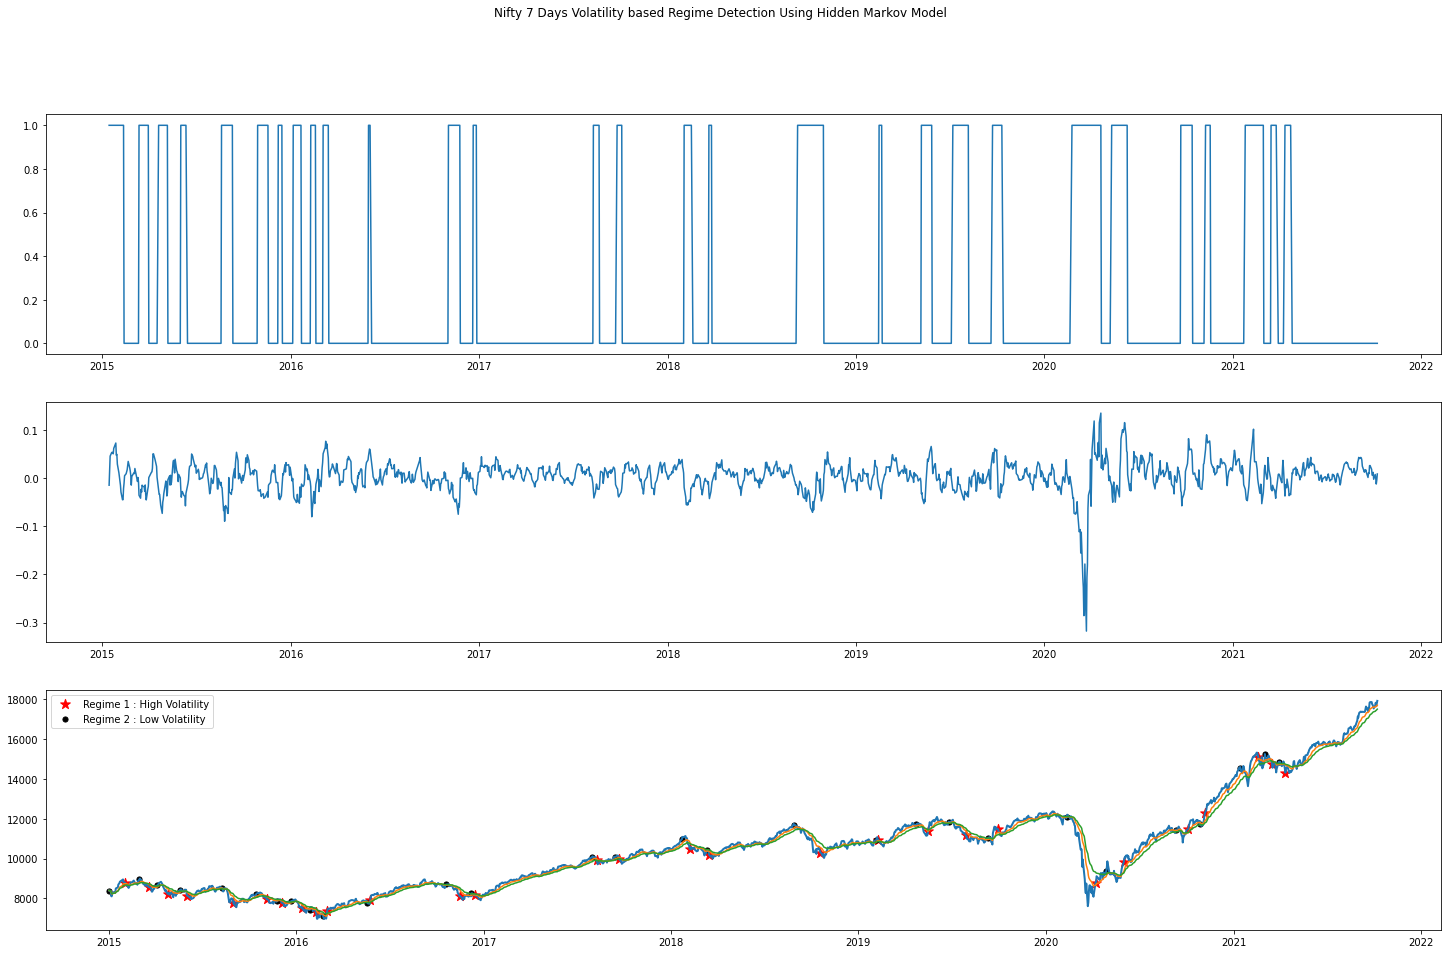

In [21]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['Close'][:],linewidth=2)
plt.plot(df["Close"].ewm(span=13).mean())
plt.plot(df["Close"].ewm(span=26).mean())
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : High Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : Low Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

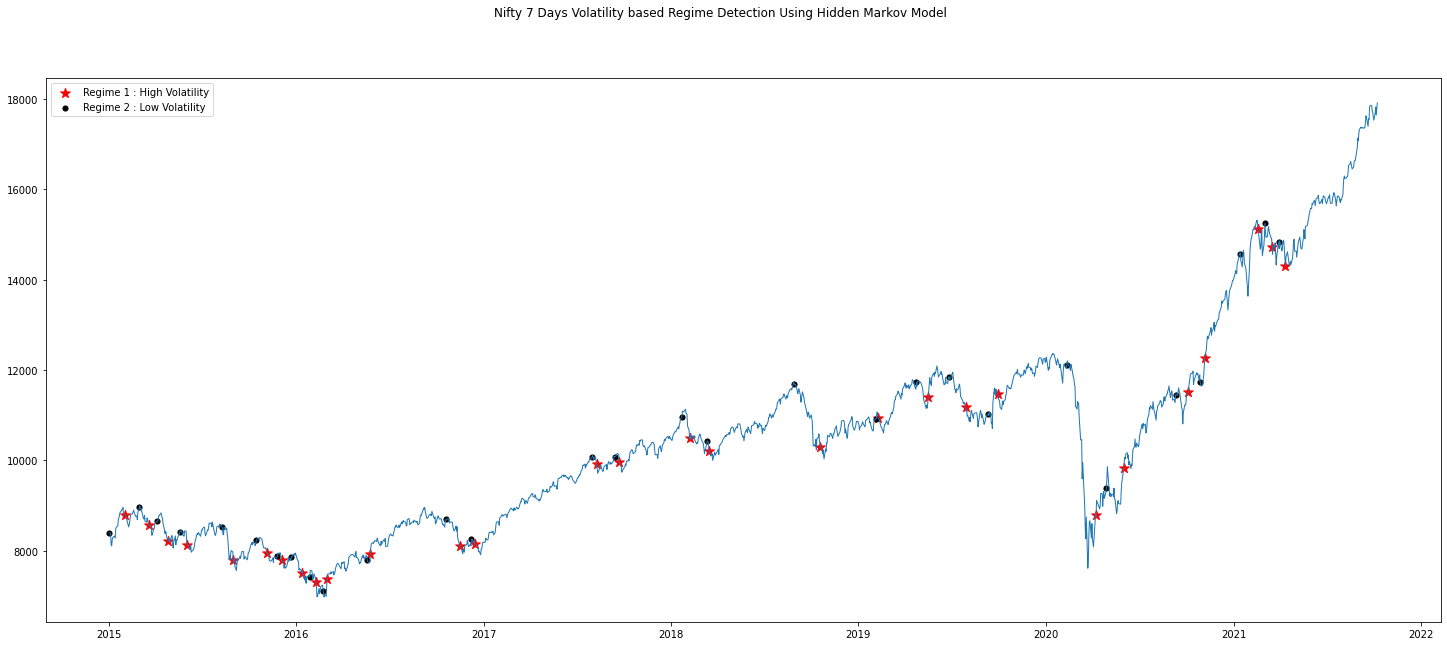

In [22]:
fig, ax = plt.subplots(figsize=(25,10),sharex=True)
plt.plot(df['Close'][:],linewidth=1)
#plt.plot(df["Close"].ewm(span=13).mean(),color='g')
#plt.plot(df["Close"].ewm(span=26).mean(),color='r')
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : High Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : Low Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

In [23]:
buy[-1],sell[-1]

(1538, 1530)

In [24]:
lst=[buy[-1],sell[-1]]
max(lst)

1538

In [25]:
df.loc[:,'Regime']=np.nan

In [26]:
df.loc[1538:,'Regime']='Low Volatility'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.


In [27]:
if max(lst)!=1538:
  df.loc[-1:,'Regime']='High Volatility'

In [28]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Regime
Date,,,,,,,
2021-10-04,17615.550781,17750.900391,17581.349609,17691.250000,17691.250000,295800,Low Volatility
2021-10-05,17661.349609,17833.449219,17640.900391,17822.300781,17822.300781,427000,Low Volatility
2021-10-06,17861.500000,17884.599609,17613.150391,17646.000000,17646.000000,395800,Low Volatility
2021-10-07,17810.550781,17857.550781,17763.800781,17790.349609,17790.349609,419900,Low Volatility
2021-10-08,17886.849609,17941.849609,17848.150391,17914.650391,17914.650391,0,Low Volatility


In [29]:
if df['Regime'][-1]!=df['Regime'][-2]:
  print(f'Change in Regime ---> Present Regime {df["Regime"][-1]}')
else:
  print(f'No Change We are in a Regime of : {df["Regime"][-1]}') 


No Change We are in a Regime of : Low Volatility


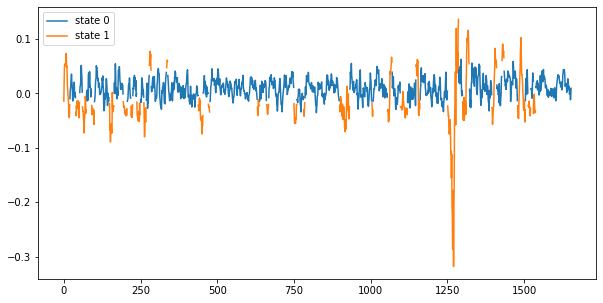

In [30]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();